# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

Ho aggiunto una funzione di scambio dei cammini tra i vari "continenti" (i core utilizzati) che ricercano il cammino migliore la quale ogni 12 generazioni ripartisce i 5 migliori cammini di ogni continente in maniera casuale tra essi, implementat in questo modo:

```cpp
void Best_Paths_Exchange(Random &rnd, vector<vector<int>> &paths, int rank, int size) {
   // Inizializzo i migliori cammini
   vector<vector<int>> best_paths(best_to_change);

   // Estraggo i migliori cammini
   for (int i=0;i<best_to_change;i++) {
      best_paths[i] = paths[i];
   }

   // Flatten il vettore dei migliori cammini
   vector<int> best_paths_flat;
   for (const auto& path : best_paths) {
      best_paths_flat.insert(best_paths_flat.end(), path.begin(), path.end());
   }

   // Raccolgo i migliori cammini da tutti i processi
   vector<int> olimpic_games_flat(size*best_to_change*path_size);
   MPI_Gather(best_paths_flat.data(), best_to_change*path_size, MPI_INT,
            olimpic_games_flat.data(), best_to_change*path_size, MPI_INT,
            0, MPI_COMM_WORLD);

   // Solo il processo root (rank 0) mischia i cammini
   if (rank == 0) {
      // Converti il flat vector in un vettore di vettori
      vector<vector<int>> olimpic_games(size*best_to_change);
      for (int i=0;i<size*best_to_change;i++) {
         olimpic_games[i] = vector<int>(olimpic_games_flat.begin() + i*path_size, olimpic_games_flat.begin() + (i+1)*path_size);
      }

      // Mischio casualmente i migliori
      Shuffler(rnd, olimpic_games);

      // Converti di nuovo in un vettore flat
      olimpic_games_flat.clear();
      for (const auto& game : olimpic_games) {
         olimpic_games_flat.insert(olimpic_games_flat.end(), game.begin(), game.end());
      }
   }

   // Distribuisci i cammini mischiati a tutti i processi
   MPI_Bcast(olimpic_games_flat.data(), size*best_to_change*path_size, MPI_INT, 0, MPI_COMM_WORLD);

   // Aggiorna i cammini migliori per ogni processo
   for (int i=0;i<best_to_change;i++) {
      paths[i] = vector<int>(olimpic_games_flat.begin() + i*path_size, olimpic_games_flat.begin() + (i+1)*path_size);
   }
};
```

I seguenti plot riportano i migliori cammini trovati da 8 core:

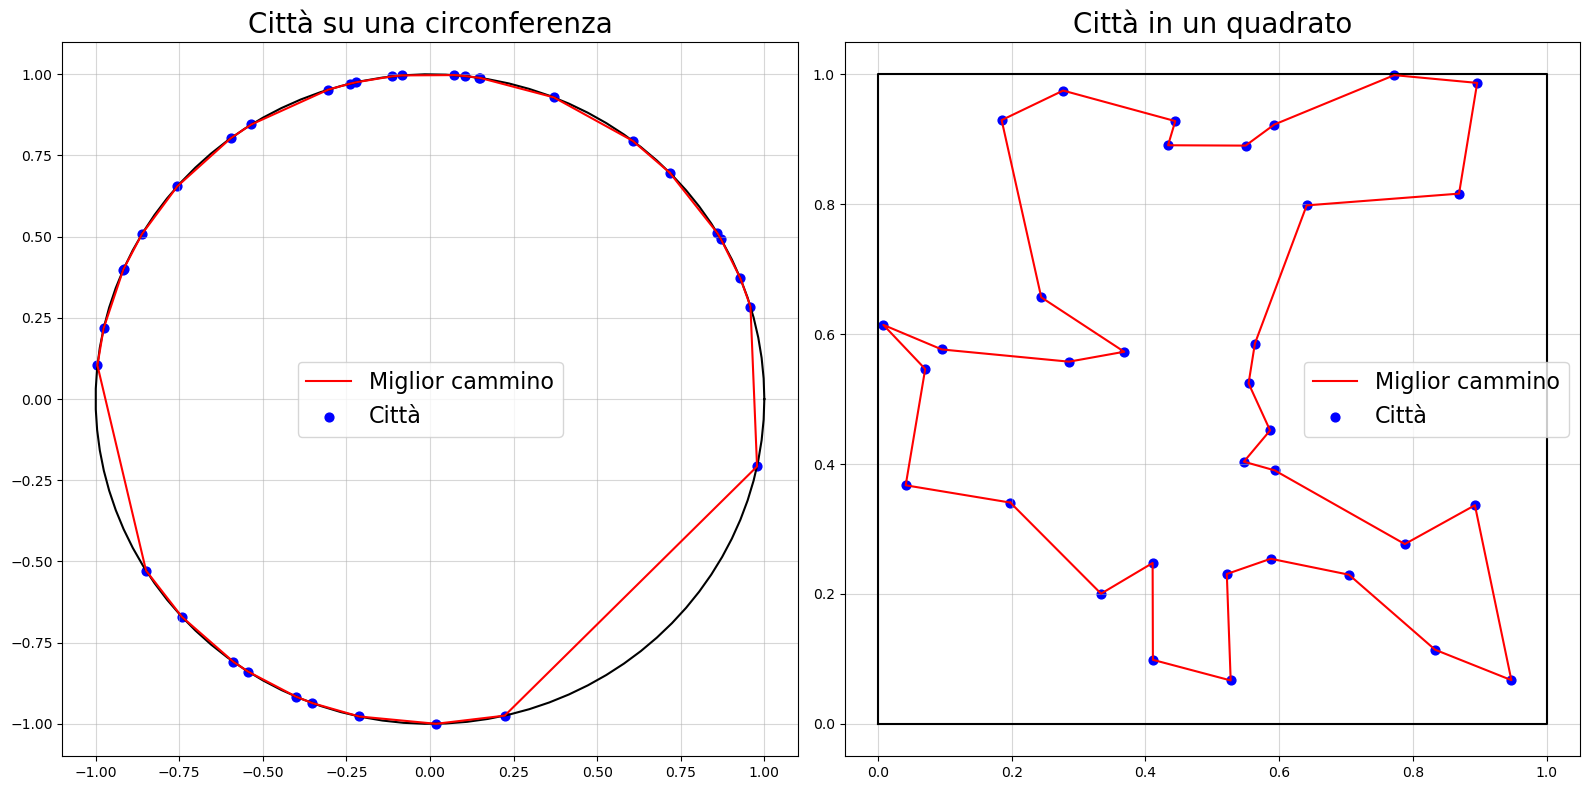

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
coordinates_circle = np.loadtxt('/home/davide/Simulazione_Numerica/Esercizio_10/Esercizio_10.1/cities_positions_circ.out')
indices_circle = np.loadtxt('/home/davide/Simulazione_Numerica/Esercizio_10/Esercizio_10.1/best_path_circ.out', dtype=int)

coordinates_square = np.loadtxt('/home/davide/Simulazione_Numerica/Esercizio_10/Esercizio_10.1/cities_positions_square.out')
indices_square = np.loadtxt('/home/davide/Simulazione_Numerica/Esercizio_10/Esercizio_10.1/best_path_square.out', dtype=int)

# Reorder coordinates based on the best path
ordered_coords_circle = coordinates_circle[indices_circle]
ordered_x_circle = ordered_coords_circle[:, 0]
ordered_y_circle = ordered_coords_circle[:, 1]

ordered_coords_square = coordinates_square[indices_square]
ordered_x_square = ordered_coords_square[:, 0]
ordered_y_square = ordered_coords_square[:, 1]

# Coordinates of the cities
x_coords_circle = coordinates_circle[:, 0]
y_coords_circle = coordinates_circle[:, 1]

x_coords_square = coordinates_square[:, 0]
y_coords_square = coordinates_square[:, 1]

# Plot
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color='k')
plt.plot(ordered_x_circle, ordered_y_circle, label='Miglior cammino', color='red')
plt.scatter(x_coords_circle, y_coords_circle, label='Città', s=40, color='blue')
plt.grid(True, alpha=0.5)
plt.legend(fontsize=16)
plt.title('Città su una circonferenza', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='k')
plt.plot(ordered_x_square, ordered_y_square, label='Miglior cammino', color='red')
plt.scatter(x_coords_square, y_coords_square, label='Città', s=40, color='blue')
plt.grid(True, alpha=0.5)
plt.legend(fontsize=16)
plt.title('Città in un quadrato', fontsize=20)

plt.tight_layout()
plt.show()


### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

In questo caso ho utilizzato 100 scambi ogni 100 generazioni con 16 core ed effettivamente utilizzando più core la ricerca del cammino ha richiesto molte meno generazioni di quelle che sarebbero state necessarie senza la parallelizzazione permettendo di eseguire il calcolo in un tempo molto più ristretto.

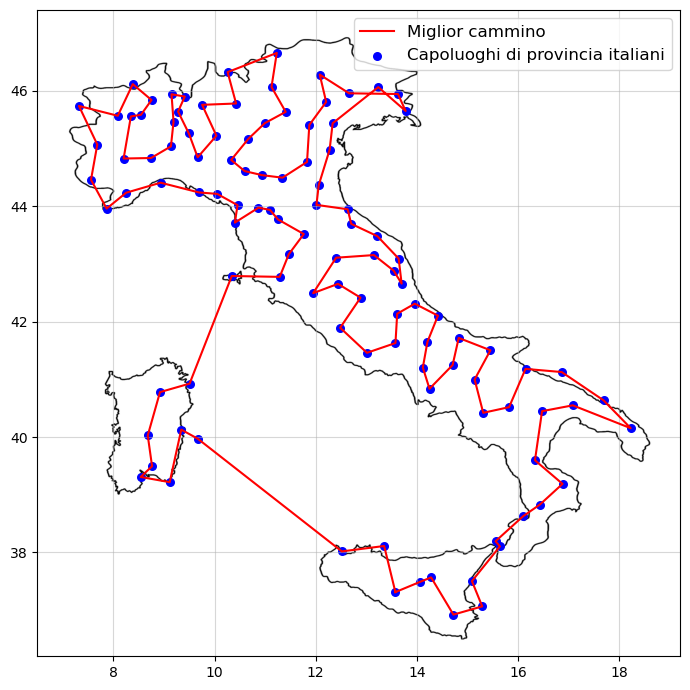

In [4]:
coordinates_ita = np.loadtxt('/home/davide/Simulazione_Numerica/Esercizio_10/Esercizio_10.2/cap_prov_ita.dat')

indices_ita = []
with open('/home/davide/Simulazione_Numerica/Esercizio_10/Esercizio_10.2/best_path_100.out', 'r') as file:
    for line in file:
        indices_ita.append(int(line.strip()))

x_coords_ita, y_coords_ita = zip(*coordinates_ita)

ordered_x_ita = [x_coords_ita[i] for i in indices_ita]
ordered_y_ita = [y_coords_ita[i] for i in indices_ita]

img = mpimg.imread('/home/davide/Simulazione_Numerica/Esercizio_10/Esercizio_10.2/cartina_Italia.png')

plt.figure(figsize=(7, 7))

plt.imshow(img, extent=[6.5, 19.2, 36.2, 47.4], aspect='auto')

plt.plot(ordered_x_ita, ordered_y_ita, label='Miglior cammino', color='red')
plt.scatter(x_coords_ita, y_coords_ita, label='Capoluoghi di provincia italiani', s=30, color='blue')
plt.grid(True, alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()